# `Splatter` Simulated Datasets
C. Heiser, 2020

---
__The purpose of this notebook is to evaluate our structural preservation metrics on a synthetic dataset of known high-dimensional structure, using simulation parameters to define global structure and compare to our metric.__  

To benchmark these techniques, we are using a [**Splatter**](https://github.com/Oshlack/splatter) simulation

In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [2]:
# create dictionaries for dumping results into
final_distance_stats = {'Continuous':{'R':{}, 'EMD':{}}, 'Discrete':{'R':{}, 'EMD':{}}}

### Continuous data with directional pseudotime - three branches from middle

In [3]:
sim_path = sc.read_csv('../inputs/sim_path.csv')
sim_path = sim_path.T
sim_path_obs = pd.read_csv('../inputs/sim_path_obs.csv', index_col=0)
sim_path.obs = sim_path_obs

In [4]:
# get useful metrics of counts data
sc.pp.calculate_qc_metrics(sim_path, inplace=True)

# preprocess AnnData for downstream dimensionality reduction
sim_path.layers['raw_counts'] = sim_path.X.copy() # save raw counts in layer
sc.pp.normalize_total(sim_path, target_sum=None, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(sim_path, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
sim_path.X = sim_path.layers['arcsinh_norm'].copy()

# see resulting AnnData contents
sim_path

AnnData object with n_obs × n_vars = 3060 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [5]:
# turn PT values into .obsm as vertical vector
sim_path.obsm['pseudotime'] = sim_path.obs['Step'].values.reshape((sim_path.n_obs,1))

In [6]:
sim_path.obs.Group.value_counts()

Path2    1040
Path3    1016
Path1    1004
Name: Group, dtype: int64

### Discrete data with directional pseudotime - three branches from middle

In [7]:
sim_discrete = sc.read_csv('../inputs/sim_discrete.csv')
sim_discrete = sim_discrete.T
sim_discrete_obs = pd.read_csv('../inputs/sim_discrete_obs.csv', index_col=0)
sim_discrete.obs = sim_discrete_obs

In [8]:
# get useful metrics of counts data
sc.pp.calculate_qc_metrics(sim_discrete, inplace=True)

# preprocess AnnData for downstream dimensionality reduction
sim_discrete.layers['raw_counts'] = sim_discrete.X.copy() # save raw counts in layer
sc.pp.normalize_total(sim_discrete, target_sum=None, layers=None, key_added='norm_factor') # normalize within each cell to get fractional counts
arcsinh(sim_discrete, scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
sim_discrete.X = sim_discrete.layers['arcsinh_norm'].copy()

# see resulting AnnData contents
sim_discrete

AnnData object with n_obs × n_vars = 1873 × 500 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'norm_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

In [9]:
# turn PT values into .obsm as vertical vector
sim_discrete.obsm['pseudotime'] = sim_discrete.obs['Step'].values.reshape((sim_discrete.n_obs,1))

In [10]:
sim_discrete.obs.Group.value_counts()

Path2    660
Path1    623
Path3    590
Name: Group, dtype: int64

In [11]:
def pairwise_sums(v1, v2):
    out = np.repeat(v1, len(v2), axis=1) + np.repeat(v2, len(v1), axis=1).T
    return out.flatten()


def cluster_arrangement_PT(
    adata,
    post,
    obs_col,
    IDs,
    ID_names=None,
    figsize=(4, 4),
    legend=True,
    ax_labels=["Native", "Latent"],
):
    """
    determine pairwise distance preservation between 3 IDs from adata.obs[obs_col]
        adata = anndata object to pull dimensionality reduction from
        pre = matrix to subset as pre-transformation (i.e. adata.X)
        post = matrix to subset as pre-transformation (i.e. adata.obsm['X_pca'])
        obs_col = name of column in adata.obs to use as cell IDs (i.e. 'louvain')
        IDs = list of THREE IDs to compare (i.e. [0,1,2])
        figsize = size of resulting axes
        legend = display legend on plot
        ax_labels = list of two strings for x and y axis labels, respectively. if False, exclude axis labels.
    """
    # distance calculations for pre_obj
    dist_0_1 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[0]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[1]])
    dist_0_2 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[0]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[2]])
    dist_1_2 = pairwise_sums(adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[1]], adata.obsm['pseudotime'][adata.obs[obs_col] == IDs[2]])
    # combine and min-max normalize
    dist = np.append(np.append(dist_0_1, dist_0_2), dist_1_2)
    dist = dist.astype(float)
    dist -= dist.min()
    dist /= dist.ptp()
    # split normalized distances by cluster pair
    dist_norm_0_1 = dist[: dist_0_1.shape[0]]
    dist_norm_0_2 = dist[dist_0_1.shape[0] : dist_0_1.shape[0] + dist_0_2.shape[0]]
    dist_norm_1_2 = dist[dist_0_1.shape[0] + dist_0_2.shape[0] :]

    # distance calculations for post_obj
    post_0_1 = cdist(
        post[adata.obs[obs_col] == IDs[0]], post[adata.obs[obs_col] == IDs[1]]
    ).flatten()
    post_0_2 = cdist(
        post[adata.obs[obs_col] == IDs[0]], post[adata.obs[obs_col] == IDs[2]]
    ).flatten()
    post_1_2 = cdist(
        post[adata.obs[obs_col] == IDs[1]], post[adata.obs[obs_col] == IDs[2]]
    ).flatten()
    # combine and min-max normalize
    post = np.append(np.append(post_0_1, post_0_2), post_1_2)
    post -= post.min()
    post /= post.ptp()
    # split normalized distances by cluster pair
    post_norm_0_1 = post[: post_0_1.shape[0]]
    post_norm_0_2 = post[post_0_1.shape[0] : post_0_1.shape[0] + post_0_2.shape[0]]
    post_norm_1_2 = post[post_0_1.shape[0] + post_0_2.shape[0] :]

    # calculate EMD and Pearson correlation stats
    EMD = [
        wasserstein_1d(dist_norm_0_1, post_norm_0_1),
        wasserstein_1d(dist_norm_0_2, post_norm_0_2),
        wasserstein_1d(dist_norm_1_2, post_norm_1_2),
    ]
    corr_stats = [
        pearsonr(x=dist_0_1, y=post_0_1)[0],
        pearsonr(x=dist_0_2, y=post_0_2)[0],
        pearsonr(x=dist_1_2, y=post_1_2)[0],
    ]

    if ID_names is None:
        ID_names = IDs.copy()

    # generate jointplot
    g = sns.JointGrid(x=dist, y=post, space=0, height=figsize[0])
    g.plot_joint(plt.hist2d, bins=50, cmap=sns.cubehelix_palette(as_cmap=True))
    sns.kdeplot(
        dist_norm_0_1,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkorange",
        label=ID_names[0] + " - " + ID_names[1],
        legend=legend,
    )
    sns.kdeplot(
        dist_norm_0_2,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkgreen",
        label=ID_names[0] + " - " + ID_names[2],
        legend=legend,
    )
    sns.kdeplot(
        dist_norm_1_2,
        shade=False,
        bw=0.01,
        ax=g.ax_marg_x,
        color="darkred",
        label=ID_names[1] + " - " + ID_names[2],
        legend=legend,
    )
    if legend:
        g.ax_marg_x.legend(loc=(1.01, 0.1))

    sns.kdeplot(
        post_norm_0_1,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkorange",
        ax=g.ax_marg_y,
    )
    sns.kdeplot(
        post_norm_0_2,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkgreen",
        ax=g.ax_marg_y,
    )
    sns.kdeplot(
        post_norm_1_2,
        shade=False,
        bw=0.01,
        vertical=True,
        color="darkred",
        ax=g.ax_marg_y,
    )
    g.ax_joint.plot(
        np.linspace(max(dist.min(), post.min()), 1, 100),
        np.linspace(max(dist.min(), post.min()), 1, 100),
        linestyle="dashed",
        color=sns.cubehelix_palette()[-1],
    )  # plot identity line as reference for regression
    if ax_labels:
        plt.xlabel(ax_labels[0], fontsize="xx-large", color=sns.cubehelix_palette()[-1])
        plt.ylabel(ax_labels[1], fontsize="xx-large", color=sns.cubehelix_palette()[2])

    plt.tick_params(labelleft=False, labelbottom=False)

    return corr_stats, EMD

---
## Principal Component Analysis

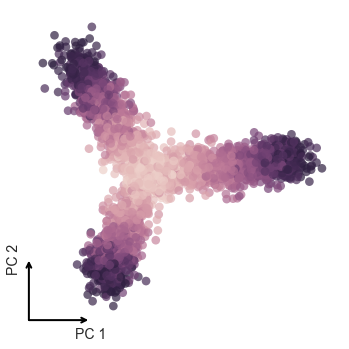

In [12]:
sc.tl.pca(sim_path, n_comps=500)
sim_path.obsm['PCA500'] = sim_path.obsm['X_pca'].copy()
DR_plot(dim_name='PC').plot(sim_path.obsm['PCA500'], color=sim_path.obs['Step'])

We can test the Euclidean distance preservation as follows:

In [13]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

Calculating unique distances for native space, X
Calculating unique distances for latent space, PCA500
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
30-nearest neighbor calculation for native space, X
30-nearest neighbor calculation for latent space, PCA500
Determining nearest neighbor preservation
Done!
R: 1.0
EMD: 0.0
Knn Pres.: 100.0
CPU times: user 1min 55s, sys: 479 ms, total: 1min 56s
Wall time: 22.7 s


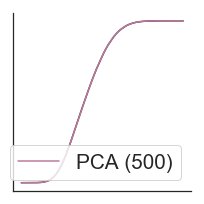

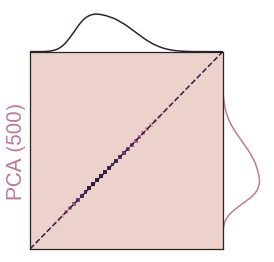

In [14]:
%%time
corr, EMD, knn = structure_preservation_sc(adata=sim_path, latent='PCA500', k=k)
print('R: {}\nEMD: {}\nKnn Pres.: {}'.format(round(corr[0], 4), round(EMD, 4), round(knn, 4)))
SP_plot(pre_norm=sim_path.uns['X_norm_distances'], post_norm=sim_path.uns['PCA500_norm_distances'], labels=['','PCA (500)'], figsize=(3,3)).plot_cumulative_distributions()
SP_plot(pre_norm=sim_path.uns['X_norm_distances'], post_norm=sim_path.uns['PCA500_norm_distances'], labels=['','PCA (500)']).joint_plot_distance_correlation()

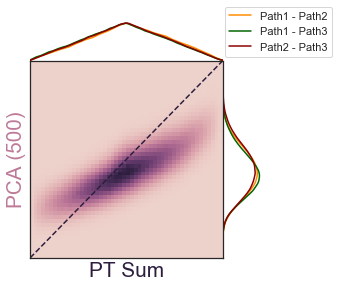

In [15]:
corr_stats_pca500, EMD_pca500 = cluster_arrangement_PT(sim_path, post=sim_path.obsm["PCA500"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["PT Sum", "PCA (500)"])

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

---
# 2-Component PCA

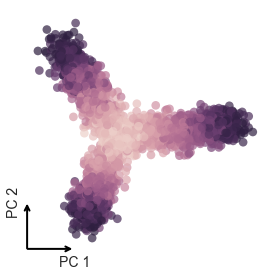

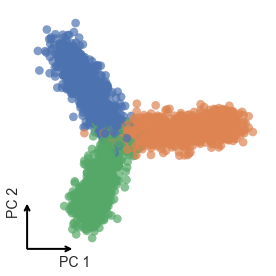

In [18]:
sc.tl.pca(sim_path, n_comps=2)
sim_path.obsm['PCA2'] = sim_path.obsm['X_pca'].copy()
DR_plot(dim_name='PC', figsize=(4,4)).plot(sim_path.obsm['PCA2'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_PCA_step.png")
DR_plot(dim_name='PC', figsize=(4,4)).plot(sim_path.obsm['PCA2'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_PCA_group.png")

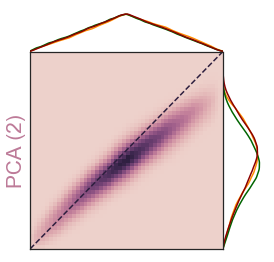

In [21]:
corr_stats_pca2, EMD_pca2 = cluster_arrangement_PT(sim_path, post=sim_path.obsm["PCA2"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "PCA (2)"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_PCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['PCA (2)'], final_distance_stats['Continuous']['EMD']['PCA (2)'] = corr_stats_pca2, EMD_pca2

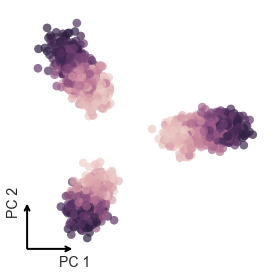

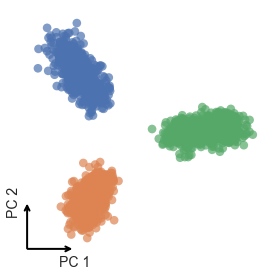

In [22]:
sc.tl.pca(sim_discrete, n_comps=2)
sim_discrete.obsm['PCA2'] = sim_discrete.obsm['X_pca'].copy()
DR_plot(dim_name='PC', figsize=(4,4)).plot(sim_discrete.obsm['PCA2'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_PCA_step.png")
DR_plot(dim_name='PC', figsize=(4,4)).plot(sim_discrete.obsm['PCA2'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_PCA_group.png")

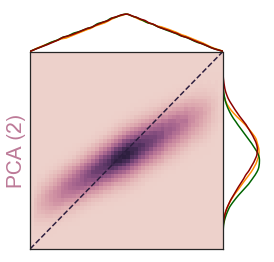

In [30]:
corr_stats_pca2, EMD_pca2 = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["PCA2"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "PCA (2)"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_PCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['PCA (2)'], final_distance_stats['Discrete']['EMD']['PCA (2)'] = corr_stats_pca2, EMD_pca2

---
# 10-Component PCA

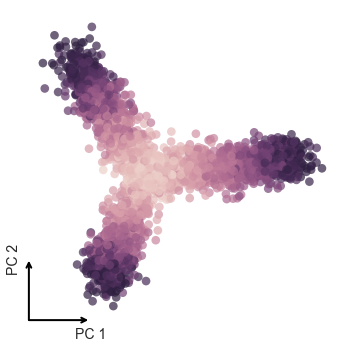

In [24]:
sc.tl.pca(sim_path, n_comps=10)
sim_path.obsm['PCA10'] = sim_path.obsm['X_pca'].copy()
DR_plot(dim_name='PC').plot(sim_path.obsm['PCA10'], color=sim_path.obs['Step'])

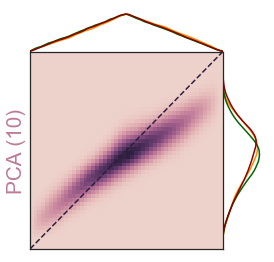

In [26]:
corr_stats_pca10, EMD_pca10 = cluster_arrangement_PT(sim_path, post=sim_path.obsm["PCA10"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "PCA (10)"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_PCA10.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['PCA (10)'], final_distance_stats['Continuous']['EMD']['PCA (10)'] = corr_stats_pca10, EMD_pca10

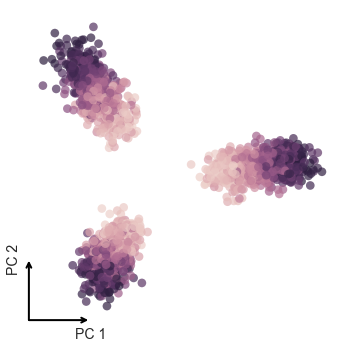

In [27]:
sc.tl.pca(sim_discrete, n_comps=10)
sim_discrete.obsm['PCA10'] = sim_discrete.obsm['X_pca'].copy()
DR_plot(dim_name='PC').plot(sim_discrete.obsm['PCA10'], color=sim_discrete.obs['Step'])

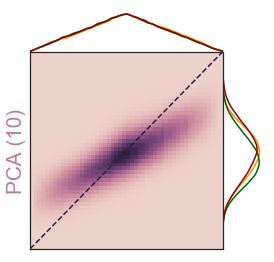

In [29]:
corr_stats_pca10, EMD_pca10 = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["PCA10"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "PCA (10)"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_PCA10.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['PCA (10)'], final_distance_stats['Discrete']['EMD']['PCA (10)'] = corr_stats_pca10, EMD_pca10

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

In [32]:
# perform t-SNE
%time sc.tl.tsne(sim_path, use_rep='X', perplexity=30, random_state=18)

CPU times: user 26.6 s, sys: 294 ms, total: 26.9 s
Wall time: 26.9 s


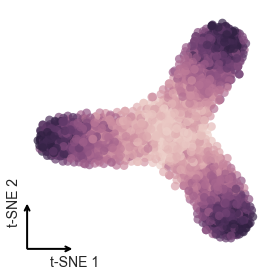

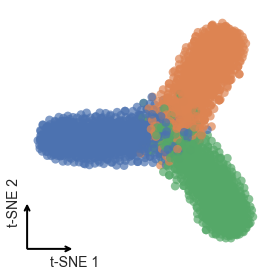

In [33]:
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot(sim_path.obsm['X_tsne'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_tSNE_step.png")
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot(sim_path.obsm['X_tsne'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_tSNE_group.png")

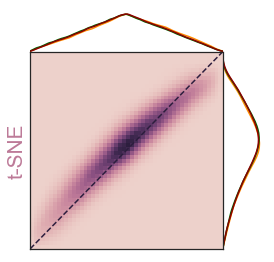

In [34]:
corr_stats_tsne, EMD_tsne = cluster_arrangement_PT(sim_path, post=sim_path.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "t-SNE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_tSNE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['t-SNE'], final_distance_stats['Continuous']['EMD']['t-SNE'] = corr_stats_tsne, EMD_tsne

In [35]:
# perform t-SNE
%time sc.tl.tsne(sim_discrete, use_rep='X', perplexity=30, random_state=18)

CPU times: user 12.3 s, sys: 63.3 ms, total: 12.3 s
Wall time: 12.3 s


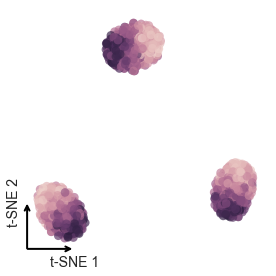

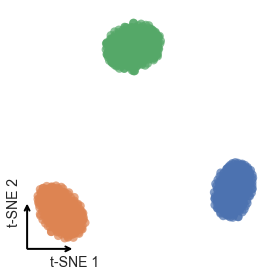

In [38]:
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot(sim_discrete.obsm['X_tsne'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_tSNE_step.png")
DR_plot(dim_name='t-SNE', figsize=(4,4)).plot(sim_discrete.obsm['X_tsne'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_tSNE_group.png")

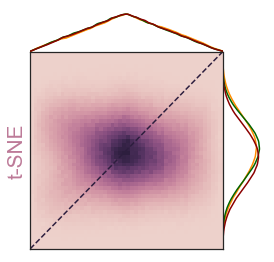

In [39]:
corr_stats_tsne, EMD_tsne = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["X_tsne"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "t-SNE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_tSNE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['t-SNE'], final_distance_stats['Discrete']['EMD']['t-SNE'] = corr_stats_tsne, EMD_tsne

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

In [40]:
%%time
# create neighborhood graphs from PCA results for UMAP
sc.pp.neighbors(sim_path, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
# perform UMAP
sc.tl.umap(sim_path, random_state=18)

CPU times: user 9.42 s, sys: 256 ms, total: 9.67 s
Wall time: 8.3 s


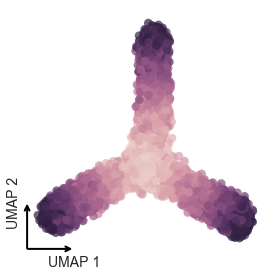

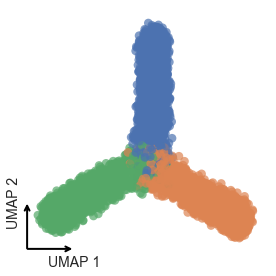

In [41]:
DR_plot(dim_name='UMAP', figsize=(4,4)).plot(sim_path.obsm['X_umap'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_UMAP_step.png")
DR_plot(dim_name='UMAP', figsize=(4,4)).plot(sim_path.obsm['X_umap'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_UMAP_group.png")

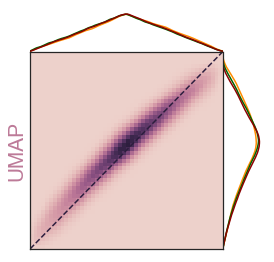

In [42]:
corr_stats_umap, EMD_umap = cluster_arrangement_PT(sim_path, post=sim_path.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "UMAP"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_UMAP.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['UMAP'], final_distance_stats['Continuous']['EMD']['UMAP'] = corr_stats_umap, EMD_umap

In [43]:
%%time
# create neighborhood graphs from PCA results for UMAP
sc.pp.neighbors(sim_discrete, n_neighbors=30, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)
# perform UMAP
sc.tl.umap(sim_discrete, random_state=18)

CPU times: user 4.02 s, sys: 152 ms, total: 4.17 s
Wall time: 3.13 s


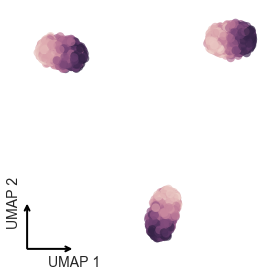

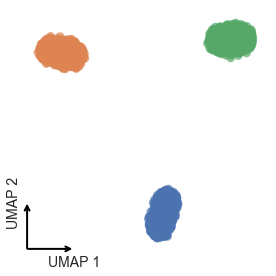

In [44]:
DR_plot(dim_name='UMAP', figsize=(4,4)).plot(sim_discrete.obsm['X_umap'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_UMAP_step.png")
DR_plot(dim_name='UMAP', figsize=(4,4)).plot(sim_discrete.obsm['X_umap'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_UMAP_group.png")

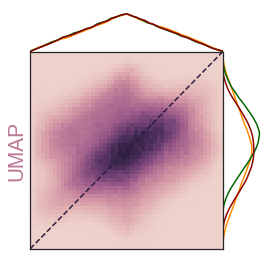

In [45]:
corr_stats_umap, EMD_umap = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["X_umap"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "UMAP"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_UMAP.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['UMAP'], final_distance_stats['Discrete']['EMD']['UMAP'] = corr_stats_umap, EMD_umap

---
### GLM-PCA

In [46]:
path_glmpca = np.genfromtxt('outputs/embeddings/sim_path_GLM-PCA.csv', delimiter=",", skip_header=1)

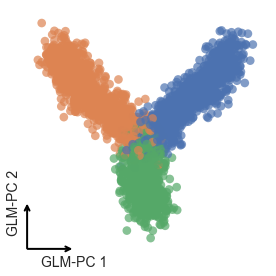

In [48]:
sim_path.obsm["glmpca"] = path_glmpca
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot(sim_path.obsm['glmpca'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_GLMPCA_step.png")
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot(sim_path.obsm['glmpca'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_GLMPCA_group.png")

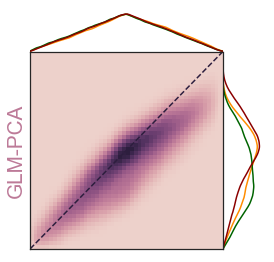

In [49]:
corr_stats_glmpca, EMD_glmpca = cluster_arrangement_PT(sim_path, post=sim_path.obsm["glmpca"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "GLM-PCA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_GLMPCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['GLM-PCA'], final_distance_stats['Continuous']['EMD']['GLM-PCA'] = corr_stats_glmpca, EMD_glmpca

In [50]:
discrete_glmpca = np.genfromtxt('outputs/embeddings/sim_discrete_GLM-PCA.csv', delimiter=",", skip_header=1)

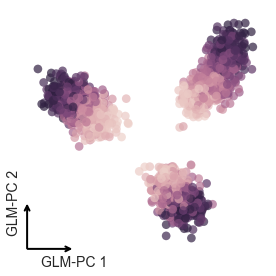

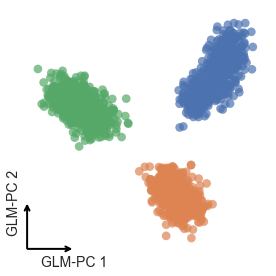

In [51]:
sim_discrete.obsm["glmpca"] = discrete_glmpca
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot(sim_discrete.obsm['glmpca'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_GLMPCA_step.png")
DR_plot(dim_name='GLM-PC', figsize=(4,4)).plot(sim_discrete.obsm['glmpca'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_GLMPCA_group.png")

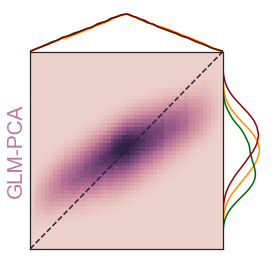

In [52]:
corr_stats_glmpca, EMD_glmpca = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["glmpca"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "GLM-PCA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_GLMPCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['GLM-PCA'], final_distance_stats['Discrete']['EMD']['GLM-PCA'] = corr_stats_glmpca, EMD_glmpca

---
### ZINB-WaVE

In [53]:
path_zinbwave = np.genfromtxt('outputs/embeddings/sim_path_ZINB-WAVE.csv', delimiter=",", skip_header=1)

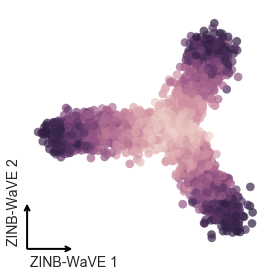

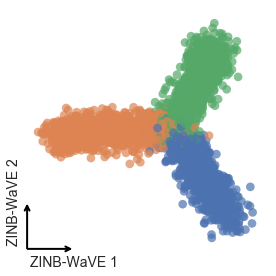

In [106]:
sim_path.obsm["zinbwave"] = path_zinbwave
DR_plot(dim_name='ZINB-WaVE', figsize=(4,4)).plot(sim_path.obsm['zinbwave'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_ZINBWAVE_step.png")
DR_plot(dim_name='ZINB-WaVE', figsize=(4,4)).plot(sim_path.obsm['zinbwave'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_ZINBWAVE_group.png")

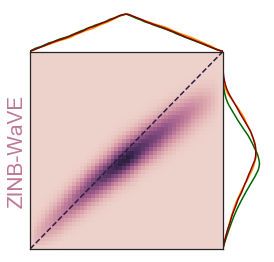

In [107]:
corr_stats_zinbwave, EMD_zinbwave = cluster_arrangement_PT(sim_path, post=sim_path.obsm["zinbwave"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "ZINB-WaVE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_ZINBWAVE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['ZINB-WaVE'], final_distance_stats['Continuous']['EMD']['ZINB-WaVE'] = corr_stats_zinbwave, EMD_zinbwave

In [56]:
discrete_zinbwave = np.genfromtxt('outputs/embeddings/sim_discrete_ZINB-WAVE.csv', delimiter=",", skip_header=1)

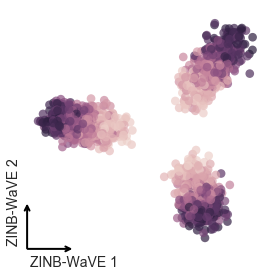

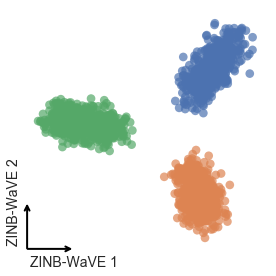

In [57]:
sim_discrete.obsm["zinbwave"] = discrete_zinbwave
DR_plot(dim_name='ZINB-WaVE', figsize=(4,4)).plot(sim_discrete.obsm['zinbwave'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_ZINBWAVE_step.png")
DR_plot(dim_name='ZINB-WaVE', figsize=(4,4)).plot(sim_discrete.obsm['zinbwave'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_ZINBWAVE_group.png")

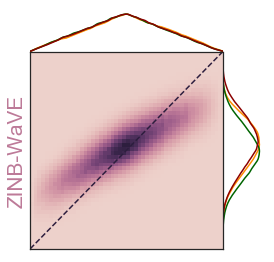

In [58]:
corr_stats_zinbwave, EMD_zinbwave = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["zinbwave"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "ZINB-WaVE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_ZINBWAVE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['ZINB-WaVE'], final_distance_stats['Discrete']['EMD']['ZINB-WaVE'] = corr_stats_zinbwave, EMD_zinbwave

---
### SIMLR

In [61]:
path_SIMLR = np.genfromtxt('outputs/embeddings/sim_path_SIMLR_ydata.csv', delimiter=",", skip_header=1)

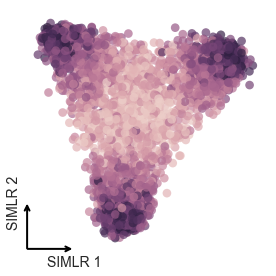

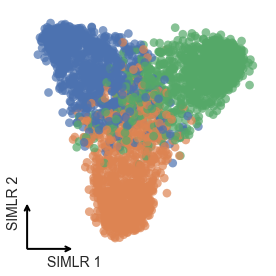

In [62]:
sim_path.obsm["SIMLR"] = path_SIMLR
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot(sim_path.obsm['SIMLR'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_SIMLR_step.png")
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot(sim_path.obsm['SIMLR'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_SIMLR_group.png")

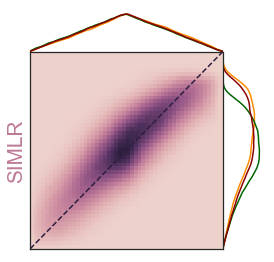

In [63]:
corr_stats_SIMLR, EMD_SIMLR = cluster_arrangement_PT(sim_path, post=sim_path.obsm["SIMLR"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "SIMLR"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_SIMLR.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['SIMLR'], final_distance_stats['Continuous']['EMD']['SIMLR'] = corr_stats_SIMLR, EMD_SIMLR

In [64]:
discrete_SIMLR = np.genfromtxt('outputs/embeddings/sim_discrete_SIMLR_ydata.csv', delimiter=",", skip_header=1)

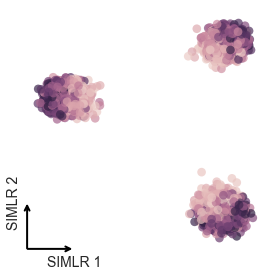

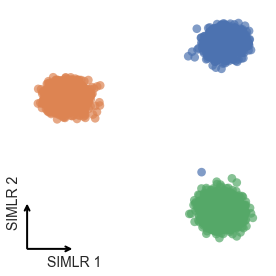

In [117]:
sim_discrete.obsm["SIMLR"] = discrete_SIMLR
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot(sim_discrete.obsm['SIMLR'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_SIMLR_step.png")
DR_plot(dim_name='SIMLR', figsize=(4,4)).plot(sim_discrete.obsm['SIMLR'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_SIMLR_group.png")

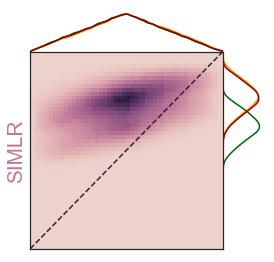

In [66]:
corr_stats_SIMLR, EMD_SIMLR = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["SIMLR"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "SIMLR"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_SIMLR.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['SIMLR'], final_distance_stats['Discrete']['EMD']['SIMLR'] = corr_stats_SIMLR, EMD_SIMLR

---
### ZIFA

In [67]:
path_ZIFA = np.genfromtxt('outputs/embeddings/sim_path_ZIFA.csv', delimiter=",")

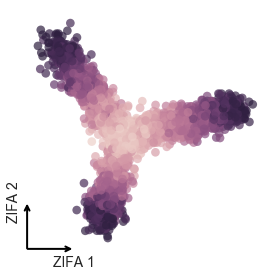

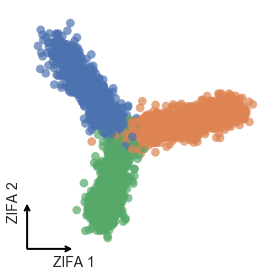

In [68]:
sim_path.obsm["ZIFA"] = path_ZIFA
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot(sim_path.obsm['ZIFA'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_ZIFA_step.png")
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot(sim_path.obsm['ZIFA'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_ZIFA_group.png")

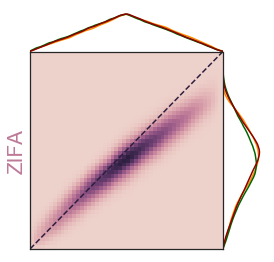

In [69]:
corr_stats_ZIFA, EMD_ZIFA = cluster_arrangement_PT(sim_path, post=sim_path.obsm["ZIFA"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "ZIFA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_ZIFA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['ZIFA'], final_distance_stats['Continuous']['EMD']['ZIFA'] = corr_stats_ZIFA, EMD_ZIFA

In [70]:
discrete_ZIFA = np.genfromtxt('outputs/embeddings/sim_discrete_ZIFA.csv', delimiter=",")

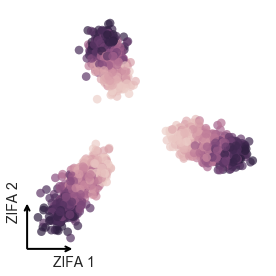

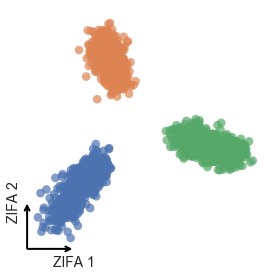

In [118]:
sim_discrete.obsm["ZIFA"] = discrete_ZIFA
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot(sim_discrete.obsm['ZIFA'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_ZIFA_step.png")
DR_plot(dim_name='ZIFA', figsize=(4,4)).plot(sim_discrete.obsm['ZIFA'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_ZIFA_group.png")

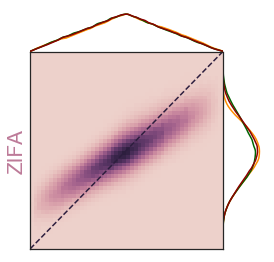

In [72]:
corr_stats_ZIFA, EMD_ZIFA = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["ZIFA"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "ZIFA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_ZIFA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['ZIFA'], final_distance_stats['Discrete']['EMD']['ZIFA'] = corr_stats_ZIFA, EMD_ZIFA

---
### FIt-SNE

In [73]:
path_FItSNE = np.genfromtxt('outputs/embeddings/sim_path_FItSNE.csv', delimiter=",")

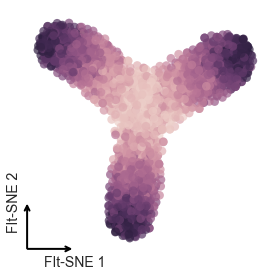

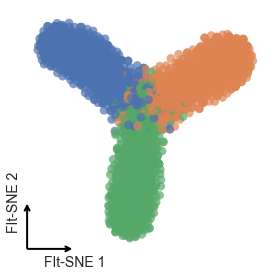

In [74]:
sim_path.obsm["FIt-SNE"] = path_FItSNE
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot(sim_path.obsm['FIt-SNE'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_FItSNE_step.png")
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot(sim_path.obsm['FIt-SNE'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_FItSNE_group.png")

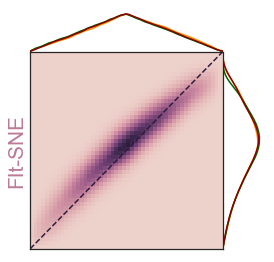

In [75]:
corr_stats_FItSNE, EMD_FItSNE = cluster_arrangement_PT(sim_path, post=sim_path.obsm["FIt-SNE"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "FIt-SNE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_FItSNE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['FIt-SNE'], final_distance_stats['Continuous']['EMD']['FIt-SNE'] = corr_stats_FItSNE, EMD_FItSNE

In [76]:
discrete_FItSNE = np.genfromtxt('outputs/embeddings/sim_discrete_FItSNE.csv', delimiter=",")

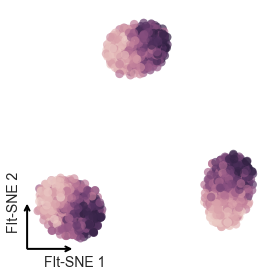

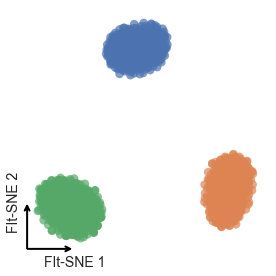

In [77]:
sim_discrete.obsm["FIt-SNE"] = discrete_FItSNE
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot(sim_discrete.obsm['FIt-SNE'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_FItSNE_step.png")
DR_plot(dim_name='FIt-SNE', figsize=(4,4)).plot(sim_discrete.obsm['FIt-SNE'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_FItSNE_group.png")

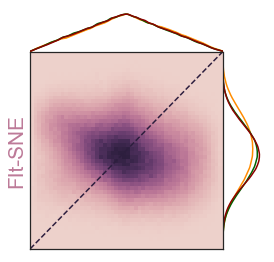

In [78]:
corr_stats_FItSNE, EMD_FItSNE = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["FIt-SNE"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "FIt-SNE"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_FItSNE.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['FIt-SNE'], final_distance_stats['Discrete']['EMD']['FIt-SNE'] = corr_stats_FItSNE, EMD_FItSNE

---
### DCA

In [79]:
path_DCA = np.genfromtxt('outputs/embeddings/sim_path_DCA/latent.tsv', delimiter="\t", usecols=(1,2))

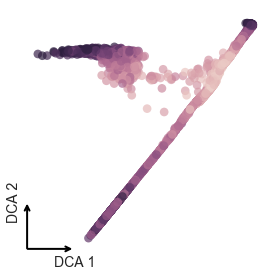

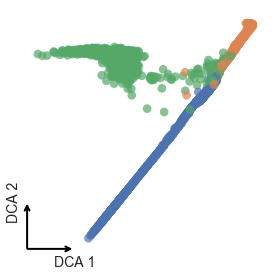

In [80]:
sim_path.obsm["DCA"] = path_DCA
DR_plot(dim_name='DCA', figsize=(4,4)).plot(sim_path.obsm['DCA'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_DCA_step.png")
DR_plot(dim_name='DCA', figsize=(4,4)).plot(sim_path.obsm['DCA'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_DCA_group.png")

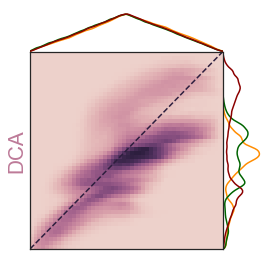

In [81]:
corr_stats_DCA, EMD_DCA = cluster_arrangement_PT(sim_path, post=sim_path.obsm["DCA"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "DCA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_DCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['DCA'], final_distance_stats['Continuous']['EMD']['DCA'] = corr_stats_DCA, EMD_DCA

In [82]:
discrete_DCA = np.genfromtxt('outputs/embeddings/sim_discrete_DCA/latent.tsv', delimiter="\t", usecols=(1,2))

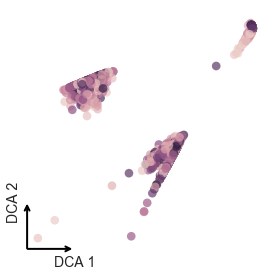

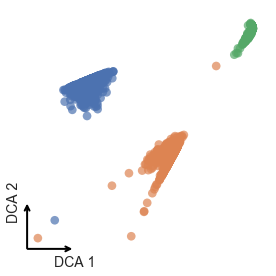

In [83]:
sim_discrete.obsm["DCA"] = discrete_DCA
DR_plot(dim_name='DCA', figsize=(4,4)).plot(sim_discrete.obsm['DCA'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_DCA_step.png")
DR_plot(dim_name='DCA', figsize=(4,4)).plot(sim_discrete.obsm['DCA'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_DCA_group.png")

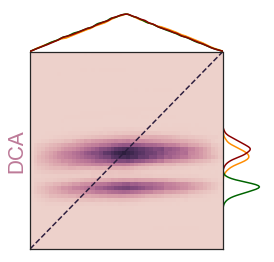

In [84]:
corr_stats_DCA, EMD_DCA = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["DCA"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "DCA"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_DCA.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['DCA'], final_distance_stats['Discrete']['EMD']['DCA'] = corr_stats_DCA, EMD_DCA

---
### scvis

In [85]:
path_scvis = np.genfromtxt('scvis_out/sim_path/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', delimiter="\t", skip_header=1, usecols=(1,2))

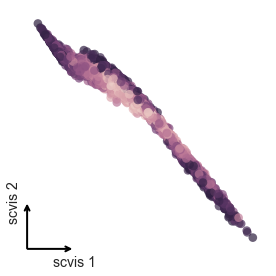

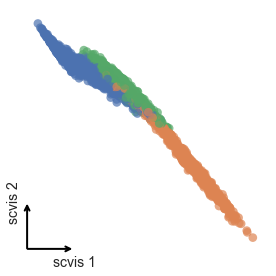

In [86]:
sim_path.obsm["scvis"] = path_scvis
DR_plot(dim_name='scvis', figsize=(4,4)).plot(sim_path.obsm['scvis'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_scvis_step.png")
DR_plot(dim_name='scvis', figsize=(4,4)).plot(sim_path.obsm['scvis'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_scvis_group.png")

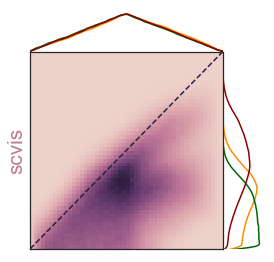

In [87]:
corr_stats_scvis, EMD_scvis = cluster_arrangement_PT(sim_path, post=sim_path.obsm["scvis"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "scvis"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_scvis.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['scvis'], final_distance_stats['Continuous']['EMD']['scvis'] = corr_stats_scvis, EMD_scvis

In [88]:
discrete_scvis = np.genfromtxt('scvis_out/sim_discrete/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv', delimiter="\t", skip_header=1, usecols=(1,2))

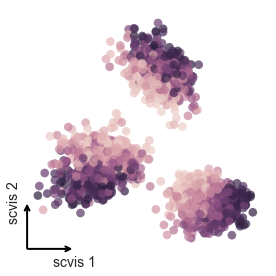

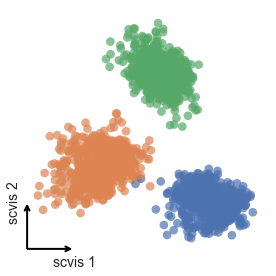

In [89]:
sim_discrete.obsm["scvis"] = discrete_scvis
DR_plot(dim_name='scvis', figsize=(4,4)).plot(sim_discrete.obsm['scvis'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_scvis_step.png")
DR_plot(dim_name='scvis', figsize=(4,4)).plot(sim_discrete.obsm['scvis'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_scvis_group.png")

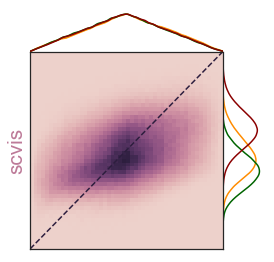

In [90]:
corr_stats_scvis, EMD_scvis = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["scvis"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "scvis"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_scvis.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['scvis'], final_distance_stats['Discrete']['EMD']['scvis'] = corr_stats_scvis, EMD_scvis

---
### scVI

In [91]:
path_scVI = np.genfromtxt('outputs/embeddings/sim_path_scVI.csv', delimiter=",")

In [92]:
sim_path.obsm["t-SNE"] = sim_path.obsm["X_tsne"].copy()

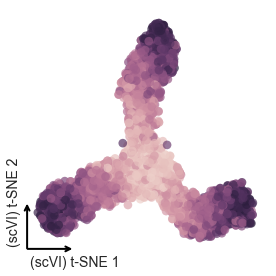

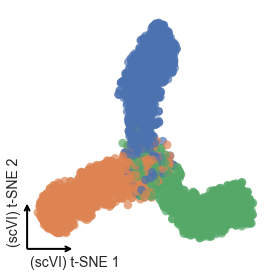

In [93]:
sim_path.obsm["scVI"] = path_scVI
sc.tl.tsne(sim_path, use_rep="scVI", perplexity=30)
sim_path.obsm["scVI_tsne"] = sim_path.obsm["X_tsne"]
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot(sim_path.obsm['scVI_tsne'], color=sim_path.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_path_scVI_step.png")
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot(sim_path.obsm['scVI_tsne'], color=sim_path.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_path_scVI_group.png")

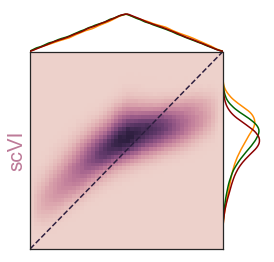

In [94]:
corr_stats_scVI, EMD_scVI = cluster_arrangement_PT(sim_path, post=sim_path.obsm["scVI"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "scVI"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_path_scVI.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Continuous']['R']['scVI'], final_distance_stats['Continuous']['EMD']['scVI'] = corr_stats_scVI, EMD_scVI

In [95]:
discrete_scVI = np.genfromtxt('outputs/embeddings/sim_discrete_scVI.csv', delimiter=",")

In [96]:
sim_discrete.obsm["t-SNE"] = sim_discrete.obsm["X_tsne"].copy()

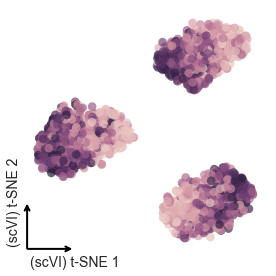

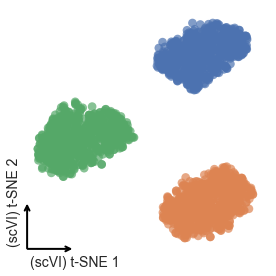

In [97]:
sim_discrete.obsm["scVI"] = discrete_scVI
sc.tl.tsne(sim_discrete, use_rep="scVI", perplexity=30)
sim_discrete.obsm["scVI_tsne"] = sim_discrete.obsm["X_tsne"]
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot(sim_discrete.obsm['scVI_tsne'], color=sim_discrete.obs['Step'], save_to="/Users/cody/Desktop/figs/sim_discrete_scVI_step.png")
DR_plot(dim_name='(scVI) t-SNE', figsize=(4,4)).plot(sim_discrete.obsm['scVI_tsne'], color=sim_discrete.obs['Group'], save_to="/Users/cody/Desktop/figs/sim_discrete_scVI_group.png")

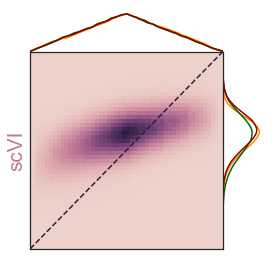

In [98]:
corr_stats_scVI, EMD_scVI = cluster_arrangement_PT(sim_discrete, post=sim_discrete.obsm["scVI"], obs_col="Group", IDs=["Path1","Path2","Path3"], ax_labels=["", "scVI"], legend=False)
plt.savefig("/Users/cody/Desktop/figs/sim_discrete_scVI.png", transparent=True)
# dump outputs into dictionary
final_distance_stats['Discrete']['R']['scVI'], final_distance_stats['Discrete']['EMD']['scVI'] = corr_stats_scVI, EMD_scVI

---
## Summary Metrics

In [108]:
continuous_EMD = pd.DataFrame(final_distance_stats['Continuous']['EMD'])

In [109]:
continuous_R = pd.DataFrame(final_distance_stats['Continuous']['R'])

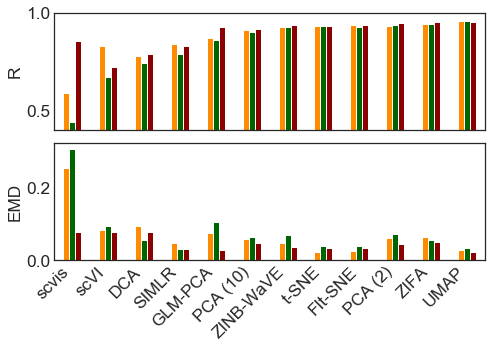

In [115]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex='col')
    continuous_R.T.iloc[np.argsort(continuous_R.T.mean(axis=1)).values,].plot(ax=axes[0], kind='bar', legend=False, color=["darkorange","darkgreen","darkred"])
    continuous_EMD.T.iloc[np.argsort(continuous_R.T.mean(axis=1)).values,].plot(ax=axes[1], kind='bar', legend=False, color=["darkorange","darkgreen","darkred"])
    axes[0].set_ylabel('R', fontsize='x-large')
    axes[0].set_yticks([0.0,0.5,1.0])
    axes[0].set_ylim([0.4, 1.0])
    axes[1].set_ylabel('EMD', fontsize='x-large')
    axes[0].tick_params(labelsize='x-large')
    axes[1].tick_params(labelsize='x-large')
    axes[1].set_xticklabels(labels=continuous_EMD.T.iloc[np.argsort(continuous_R.T.mean(axis=1)).values,].index, rotation=45, ha='right')
    plt.tight_layout()

plt.savefig("/Users/cody/Desktop/figs/sim_path_summary.png", transparent=True)

In [111]:
discrete_EMD = pd.DataFrame(final_distance_stats['Discrete']['EMD'])

In [112]:
discrete_R = pd.DataFrame(final_distance_stats['Discrete']['R'])

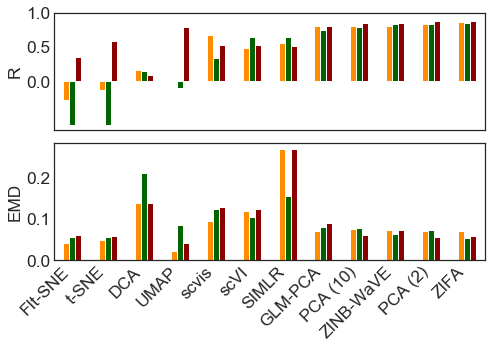

In [116]:
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex='col')
    discrete_R.T.iloc[np.argsort(discrete_R.T.mean(axis=1)).values,].plot(ax=axes[0], kind='bar', legend=False, color=["darkorange","darkgreen","darkred"])
    discrete_EMD.T.iloc[np.argsort(discrete_R.T.mean(axis=1)).values,].plot(ax=axes[1], kind='bar', legend=False, color=["darkorange","darkgreen","darkred"])
    axes[0].set_ylabel('R', fontsize='x-large')
    axes[0].set_yticks([0.0,0.5,1.0])
    axes[1].set_ylabel('EMD', fontsize='x-large')
    axes[0].tick_params(labelsize='x-large')
    axes[1].tick_params(labelsize='x-large')
    axes[1].set_xticklabels(labels=discrete_R.T.iloc[np.argsort(discrete_R.T.mean(axis=1)).values,].index, rotation=45, ha='right')
    plt.tight_layout()

plt.savefig("/Users/cody/Desktop/figs/sim_discrete_summary.png", transparent=True)